In [35]:
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import re
import cld3
from wordcloud import WordCloud, STOPWORDS 

# CA - vCA statistics

## Data source
- [vCA Aggregated - Fund 6](https://docs.google.com/spreadsheets/d/1hEUq2mCEYUk-oWaU-dFESu0lyo5zRR2HL7M7O8aURes/edit#gid=0)
- [vCA Aggregated - Fund 7](https://docs.google.com/spreadsheets/d/1ZM3ytXkMB34iSo2LamNxpver-rs9fShnpeNEia-VdBo/edit#gid=1623244429)
- [vCA Aggregated - Fund 8](https://docs.google.com/spreadsheets/d/1EFnMK1A4Umu_a6U-bYY7XHpf27Ojb_ZMzxOPngJ3wnE/edit#gid=1324970937)  
- [vCA Aggregated - Fund 8 (top vCA removed)](https://docs.google.com/spreadsheets/d/1hHp4YTEvEuOtXHZzlGESBx-UtOtd9pxjbXWXzDpyY6I/edit#gid=1439112888)  

In [36]:
# Load csv files
f6df = pd.read_csv('f6_aggregated.csv', sep=';')
f7df = pd.read_csv('f7_aggregated.csv', sep=';')
f8df = pd.read_csv('f8_aggregated.csv', sep=';')
f8df_mvp = pd.read_csv('f8_aggregated_mvp.csv', sep=';')

In [37]:
# Concatenate dataframes
df = pd.concat([f6df, f7df, f8df_mvp])

In [38]:
# Add ratings
df['avg_rating'] = (df.impact_rating + df.feasibility_rating + df.auditability_rating)/3
df['avg_avg_rating'] = df.groupby('proposal_id')['avg_rating'].transform(np.mean)
df['bias'] = df.avg_avg_rating - df.avg_rating
df.sort_values(by=['avg_avg_rating'], inplace=True, ascending=False)
dfx = df[df.result_filtered_out != 'x'].copy()
dfx['avg_avg_rating_final'] = dfx.groupby('proposal_id')['avg_rating'].transform(np.mean)
dfx.sort_values(by=['avg_avg_rating_final'], inplace=True, ascending=False)

In [39]:
funds = ['F6','F7','F8']

## Engagement

In [40]:
# Engagement
proposals = [df[df.fund == fund]['proposal_id'].value_counts().count() for fund in funds]
cas = [df[df.fund == fund]['assessor'].value_counts().count() for fund in funds]
vcas = [61, 112,84] # from google sheet tab
participation = pd.DataFrame.from_records([proposals, cas, vcas], index=['Proposals','CAs','vCAs'], columns=funds).T

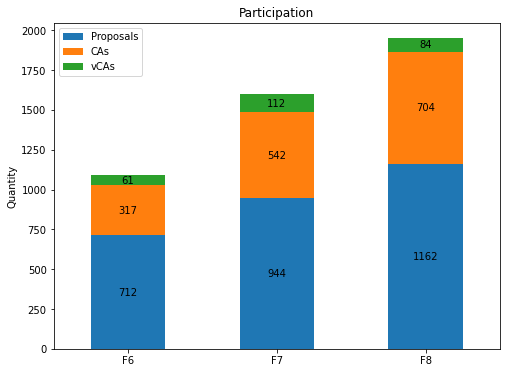

In [41]:
ax = participation.plot(kind='bar', stacked=True, figsize=(8, 6), rot=0, ylabel='Quantity', title="Participation")
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=[int(x) for x in labels], label_type='center')

## Proposal's quality

In [42]:
# Proposal's quality
good = [dfx[np.logical_and(dfx.fund == fund, dfx.avg_avg_rating_final >=4)]['proposal_id'].value_counts().count() / dfx[dfx.fund == fund]['proposal_id'].value_counts().count() for fund in funds] 
regular = [dfx[np.logical_and(np.logical_and(dfx.fund == fund, dfx.avg_avg_rating_final <4),dfx.avg_avg_rating_final >=3)]['proposal_id'].value_counts().count() /dfx[dfx.fund == fund]['proposal_id'].value_counts().count() for fund in funds]
bad = [dfx[np.logical_and(dfx.fund == fund, dfx.avg_avg_rating_final < 3)]['proposal_id'].value_counts().count() / dfx[dfx.fund == fund]['proposal_id'].value_counts().count() for fund in funds]


proposal_qa = pd.DataFrame.from_records([good, regular, bad], index=['Score > 4','Score between 3 and 4','Score < 3'], columns=funds).T

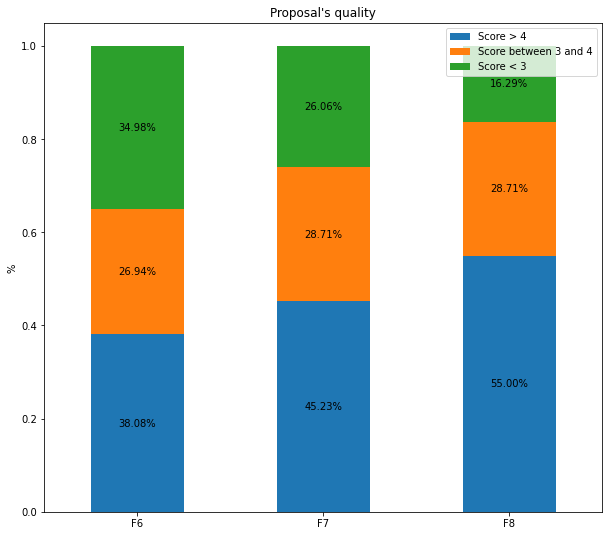

In [43]:
ax = proposal_qa.plot(kind='bar', stacked=True, figsize=(10, 9), rot=0, ylabel='%', title="Proposal's quality",mark_right = True)
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=["{:.2f}%".format(x*100) for x in labels] , label_type='center')

## CA's workload

In [44]:
# CA's quality

assessment_excellent = [df[np.logical_and(df.fund == fund, df.result_excellent == 'x')]['assesment_id'].count()  for fund in funds] 
assessment_good = [df[np.logical_and(df.fund == fund, df.result_good == 'x')]['assesment_id'].count()  for fund in funds] 
assessment_filtered_out = [df[np.logical_and(df.fund == fund, df.result_filtered_out == 'x')]['assesment_id'].count()  for fund in funds] 
assessment_qa = pd.DataFrame.from_records([assessment_excellent, assessment_good, assessment_filtered_out], index=['Excellent','Good','Filtered out'], columns=funds).T

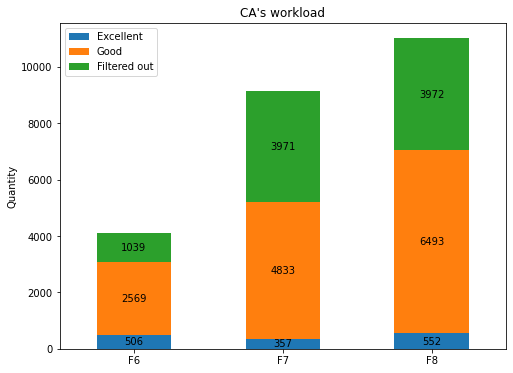

In [45]:
ax = assessment_qa.plot(kind='bar', stacked=True, figsize=(8, 6), rot=0, ylabel='Quantity', title="CA's workload")
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=[int(x) for x in labels], label_type='center')

## CA's quality

In [46]:
# CA's quality in percentage
assessment_excellent_per = [df[np.logical_and(df.fund == fund, df.result_excellent == 'x')]['assesment_id'].count() / df[df.fund == fund]['assesment_id'].count() for fund in funds] 
assessment_good_per = [df[np.logical_and(df.fund == fund, df.result_good == 'x')]['assesment_id'].count() / df[df.fund == fund]['assesment_id'].count()  for fund in funds] 
assessment_filtered_out_per = [df[np.logical_and(df.fund == fund, df.result_filtered_out == 'x')]['assesment_id'].count() / df[df.fund == fund]['assesment_id'].count() for fund in funds] 
assessment_qa_per = pd.DataFrame.from_records([assessment_excellent_per, assessment_good_per, assessment_filtered_out_per], index=['Excellent','Good','Filtered out'], columns=funds).T

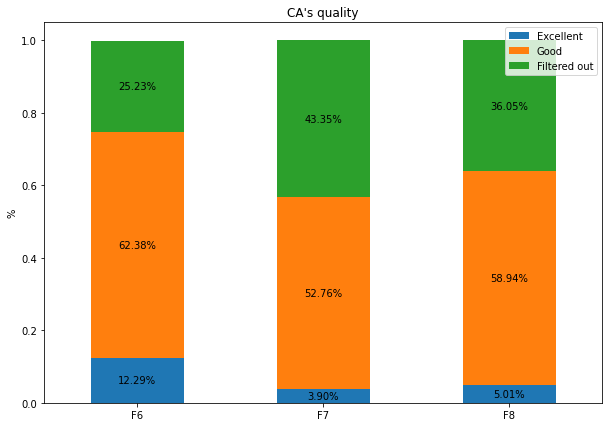

In [47]:
ax = assessment_qa_per.plot(kind='bar', stacked=True, figsize=(10, 7), rot=0, ylabel='%', title="CA's quality",mark_right = True)
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=["{:.2f}%".format(x*100) for x in labels] , label_type='center')

## vCA's workload

In [48]:
# vCA's Workload
vcarev_excellent = [df[df.fund == fund]['excellent'].sum()  for fund in funds] 
vcarev_good = [df[df.fund == fund]['good'].sum()  for fund in funds] 
vcarev_filtered_out = [df[df.fund == fund]['filtered_out'].sum()  for fund in funds] 
vcarev_qa = pd.DataFrame.from_records([vcarev_excellent, vcarev_good, vcarev_filtered_out], index=['Excellent','Good','Filtered out'], columns=funds).T

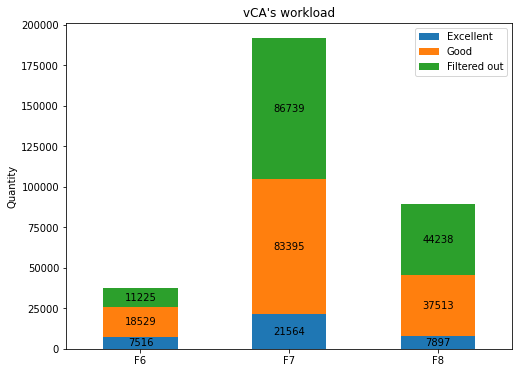

In [49]:
ax = vcarev_qa.plot(kind='bar', stacked=True, figsize=(8, 6), rot=0, ylabel='Quantity', title="vCA's workload")
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=[int(x) for x in labels], label_type='center')

## Additional stats

In [50]:
proposal_per_ca = np.divide(proposals,cas)
ca_per_vca = np.divide(cas,vcas)
assessments = [df[df.fund == fund]['assesment_id'].count() for fund in funds]
assesments_per_vca = np.divide(assessments,vcas)
reviews_by_ca_mean = [df[df.fund == fund]['assessor'].value_counts().mean() for fund in funds]
reviews_by_ca_median = [df[df.fund == fund]['assessor'].value_counts().median() for fund in funds]
reviews_by_vca_mean = [621.16, 1711.58,1067.23] # from google sheet tab
reviews_by_vca_median = [306,711,488.5] # from google sheet tab


additional_stats = pd.DataFrame.from_records([proposals, cas, vcas, proposal_per_ca,ca_per_vca,assesments_per_vca,reviews_by_ca_mean,reviews_by_ca_median,reviews_by_vca_mean,reviews_by_vca_median], index=['Proposals','CAs','vCAs','proposals/CAs','CAs/vCAs','Assesments/vCA',"CA's assessments [mean]","CA's assessments [median]","vCA's reviews [mean]","vCA's reviews [median]"], columns=funds)
pd.options.display.float_format = "{:,.2f}".format

In [51]:
display(additional_stats)

,F6,F7,F8
Proposals,712.00,944.00,"1,162.00"
CAs,317.00,542.00,704.00
vCAs,61.00,112.00,84.00
proposals/CAs,2.25,1.74,1.65
CAs/vCAs,5.20,4.84,8.38
Assesments/vCA,67.51,81.79,131.15
CA's assessments [mean],12.99,16.90,15.65
CA's assessments [median],5.00,4.00,6.50
vCA's reviews [mean],621.16,"1,711.58","1,067.23"
vCA's reviews [median],306.00,711.00,488.50


## Final scores

### Fund 6

In [52]:
# Print final scores
fund = 'F6'
challenges = dfx[dfx.fund == fund]['challenge'].value_counts()
for chall in challenges.index.tolist():
    print('****** '+chall+' ******')
    for prop in dfx[np.logical_and(dfx['challenge']==chall, dfx.fund == fund)].groupby(['idea_title'],sort=False)['avg_avg_rating_final'].mean().iteritems():
        print('{}{}'.format(prop[0].ljust(50), '{:.2f}'.format(prop[1])))
    print(' ')

****** F6: DApps & Integrations ******
Win-Win Dispute Resolution                        5.00
P2P IoT Marketplaces - Adosia IoT                 4.89
Dapp to control/monetize your data                4.80
Cardax - DEX on Cardano phase 2,3,4               4.67
SuBChain: Subsea Data Ledger                      4.67
ADAPlus.io - Mass payments system                 4.62
AdaQuest(aka The Quest for Ada)                   4.57
Liquifi V2 - efficient DEX protocol               4.50
Zero-interest-penalty CD Token                    4.50
Tales In The Blocks|Collab-writing                4.50
Private Transactions on Cardano                   4.47
Mirqur DEX - Improved LP Interface                4.44
Connect discord with cardano                      4.44
Estati - Real Estate Investments                  4.42
Arbitration for Smart Contracts                   4.40
Cardano features for everyone                     4.33
ALLIN Betting Ecosystem                           4.33
Blockademia Verification S

### Fund 7

In [53]:
# Print final scores
fund = 'F7'
challenges = dfx[dfx.fund == fund]['challenge'].value_counts()
for chall in challenges.index.tolist():
    print('****** '+chall+' ******')
    for prop in dfx[np.logical_and(dfx['challenge']==chall, dfx.fund == fund)].groupby(['idea_title'],sort=False)['avg_avg_rating_final'].mean().iteritems():
        print('{}{}'.format(prop[0].ljust(50), '{:.2f}'.format(prop[1])))
    print(' ')

****** F7: Community Events ******
Insight Sharing Workshops - TCS                   4.83
Idea Fest by Catalyst Swarm                       4.79
Cardano4Climate Community Events                  4.78
Catalyst Swarm 2022 GitBook                       4.76
QA-DAO Transcription Service                      4.71
Bridge Builders - Governance Events               4.62
After Town Hall by Catalyst Swarm                 4.59
Catalyst Events 4 Vietnam Students                4.58
Mini Proposal Workshops                           4.57
Dumpling Twitter Space                            4.52
Challenge Fest by Catalyst Swarm                  4.48
Co-Creating Events Together                       4.48
Cardano event in a Parisian Theatre               4.43
Haskell & Coffee ☕                                4.42
Clubs+hackathons = Cardano adoption               4.41
Add a calender for community events               4.39
Mass Cardano Education for Students               4.38
Eastern Town Hall             

### Fund 8

In [54]:
# Print final scores
fund = 'F8'
challenges = dfx[dfx.fund == fund]['challenge'].value_counts()
for chall in challenges.index.tolist():
    print('****** '+chall+' ******')
    for prop in dfx[np.logical_and(dfx['challenge']==chall, dfx.fund == fund)].groupby(['idea_title'],sort=False)['avg_avg_rating_final'].mean().iteritems():
        print('{}{}'.format(prop[0].ljust(50), '{:.2f}'.format(prop[1])))
    print(' ')

****** F8: DApps and Integrations ******
BWORKs - Smart contract HR platform               5.00
Done Collectively Discord Integrati               5.00
Cardano Beam - GPS based Assets                   5.00
cBilling - Cardano Billing DApp                   4.93
Control your data w Profila part 2                4.92
PeakChain Carsharing Platform                     4.92
StreamCardano: serverless infra                   4.83
Oracle Developer Portal                           4.83
Neuro tools for teams & growth                    4.78
HYDRA for mashup, co-authors and ©️               4.78
Anonymity/data control ZKT (part 2)               4.78
DirectEd - Donations dApp                         4.75
Aedou, Learn Languages Together (2)               4.75
Carbon Marketplace and Exchange                   4.75
ADA-DESO Templates to Test dApps                  4.73
Proposer-tool on chain - AIM                      4.73
Liquidity Aggregator for Cardano                  4.67
Artificial Intelligence/

## Fancy wordcloud from CA's feedack

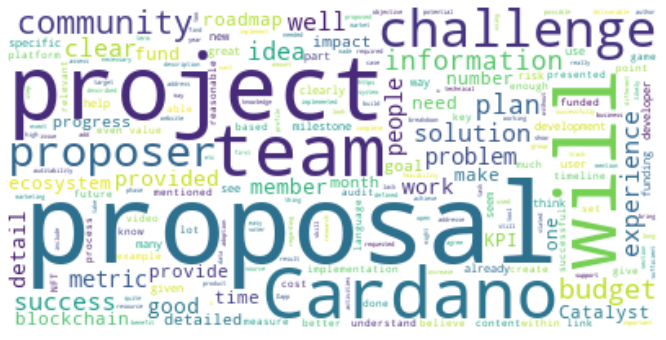

In [55]:
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(dfx['impact_note'].str.cat(sep=" ")+dfx['feasibility_note'].str.cat(sep=" ")+dfx['auditability_note'].str.cat(sep=" "))
plt.figure( figsize=(15,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## CA bias from average score histogram

### Fund 6

<AxesSubplot:>

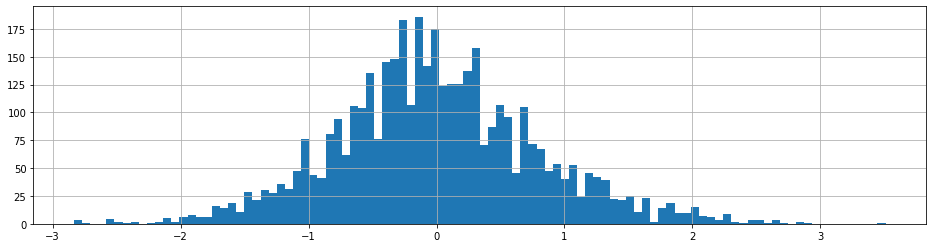

In [56]:
# Assesment bias from average scrore
df[df.fund == 'F6']['bias'].hist(figsize=(16,4),bins=100)

### Fund 7

<AxesSubplot:>

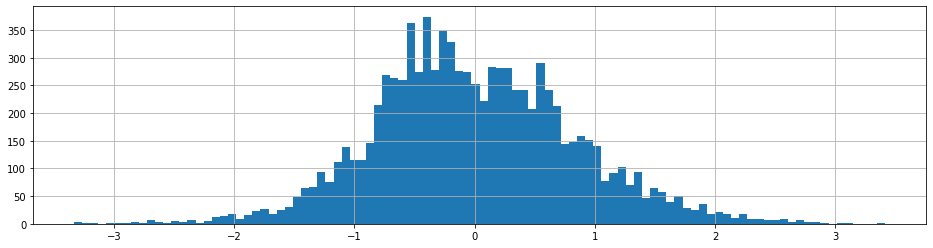

In [57]:
df[df.fund == 'F7']['bias'].hist(figsize=(16,4),bins=100)

### Fund 8

<AxesSubplot:>

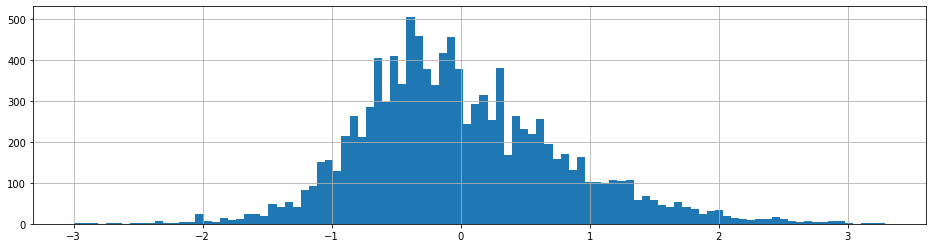

In [58]:
df[df.fund == 'F8']['bias'].hist(figsize=(16,4),bins=100)